In [1]:
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import preprocessing

import numpy as np

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph

from gensim.models import Word2Vec

import warnings
import collections
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import networkx as nx

%matplotlib inline

C:\Users\HP\miniconda3\envs\priovar-env-new\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
walk_length = 100  # maximum length of a random walk to use throughout this notebook

In [3]:
def jaccard_weights(graph, _subjects, edges):
    sources = graph.node_features(edges.source)
    targets = graph.node_features(edges.target)

    intersection = np.logical_and(sources, targets)
    union = np.logical_or(sources, targets)

    return intersection.sum(axis=1) / union.sum(axis=1)

In [8]:
import torch

def read_tensor_data(edge_index_path, edge_weight_path):
    edge_index = torch.load(edge_index_path)
    edge_weight = torch.load(edge_weight_path)
    G = nx.Graph()
    edge_set = set()
    count = 0
    for i in range(edge_index.size(1)):
        src = edge_index[0, i].item()
        dst = edge_index[1, i].item()
        weight = edge_weight[i].item()
        
        # Check if the edge already exists in the set
        if (src, dst) in edge_set:
            # Update the weight of the existing edge with the larger weight value
            G[src][dst]["weight"] = max(G[src][dst]["weight"], weight)
            count += 1
            if count % 1000 == 0:
                print(f"source: {src}, destination: {dst}, weight: {weight}")
        else:
            # Add the edge to the graph and the set
            G.add_edge(src, dst, weight=weight)
            edge_set.add((src, dst))
    return G

In [9]:
# read the tensors data/edge_index.pt and data/edge_weight.pt into a networkx graph
G = read_tensor_data("../data/edge_index.pt", "../data/edge_weight.pt")

source: 674.0, destination: 22854.0, weight: 1.0
source: 1583.0, destination: 20234.0, weight: 1.0
source: 2437.0, destination: 24580.0, weight: 1.0
source: 3498.0, destination: 20691.0, weight: 1.0
source: 3764.0, destination: 19684.0, weight: 1.0
source: 4145.0, destination: 29418.0, weight: 1.0
source: 15440.0, destination: 21815.0, weight: 1.0
source: 5448.0, destination: 21246.0, weight: 1.0
source: 6056.0, destination: 21154.0, weight: 1.0
source: 6063.0, destination: 19970.0, weight: 1.0
source: 6385.0, destination: 21244.0, weight: 1.0
source: 6681.0, destination: 20650.0, weight: 1.0
source: 7047.0, destination: 21195.0, weight: 1.0
source: 7685.0, destination: 22695.0, weight: 1.0
source: 8293.0, destination: 21292.0, weight: 1.0
source: 8811.0, destination: 20523.0, weight: 1.0
source: 15710.0, destination: 21205.0, weight: 1.0
source: 10205.0, destination: 23404.0, weight: 1.0
source: 10687.0, destination: 19685.0, weight: 1.0
source: 11111.0, destination: 35878.0, weight: 

In [10]:
# print the number of nodes and edges in the networkx graph
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 51681
Number of edges: 12283287
Average degree: 475.3502


In [5]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, subjects = dataset.load(
    largest_connected_component_only=True,
    edge_weights=jaccard_weights,
    str_node_ids=True,  # Word2Vec requires strings, not ints
)

In [6]:
print(G.info())
print(type(G))

StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 5209

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5209]
        Weights: range=[0, 1], mean=0.0946879, std=0.0918164
        Features: none
<class 'stellargraph.core.graph.StellarGraph'>


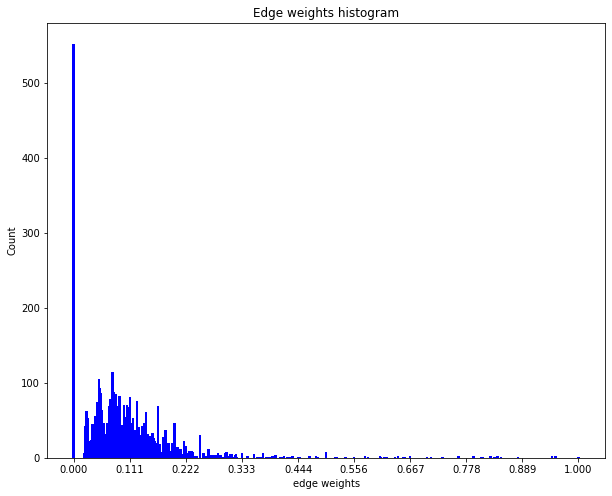

In [9]:
_, weights = G.edges(include_edge_weight=True)

wt, cnt = np.unique(weights, return_counts=True)

plt.figure(figsize=(10, 8))
plt.bar(wt, cnt, width=0.005, color="b")
plt.title("Edge weights histogram")
plt.ylabel("Count")
plt.xlabel("edge weights")
plt.xticks(np.linspace(0, 1, 10))

plt.show()

In [10]:
rw = BiasedRandomWalk(G)

In [11]:
weighted_walks = rw.run(
    nodes=G.nodes(),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=True,  # for weighted random walks
    seed=42,  # random seed fixed for reproducibility
)
print("Number of random walks: {}".format(len(weighted_walks)))

Number of random walks: 24850


In [13]:
weighted_model = Word2Vec(
    weighted_walks, vector_size=128, window=5, min_count=0, sg=1, workers=1, epochs=1
)

In [14]:
# The embedding vectors can be retrieved from model.wv using the node ID as key.
# E.g., for node id '19231', the embedding vector is retrieved as
emb = weighted_model.wv["19231"]
emb.shape

(128,)

In [15]:
emb

array([-0.4041692 ,  0.58450395, -0.2850358 , -0.44010586, -0.03451179,
        0.0928195 ,  0.10425624, -0.35619432,  0.31116167, -0.06148972,
        0.58837354, -0.06228484,  0.22448531, -0.70150685, -0.84479785,
       -0.33806005, -0.7915061 ,  0.30241784, -0.5347174 , -0.00888136,
       -0.09656193, -0.35961953, -0.5523206 , -0.05735344, -0.05256036,
       -0.13239701,  0.03944539, -0.01399144,  0.02144285, -0.36483812,
        0.19567104, -0.44615927,  0.4828628 , -0.1265296 ,  0.4197108 ,
       -0.4258617 , -1.0224453 , -0.15074706, -0.2913872 ,  0.0967893 ,
       -0.27512968,  0.11957007, -0.3697544 , -0.12684067,  0.64048964,
        0.24666576, -0.06103071,  0.2709596 ,  0.65753144,  0.6544483 ,
       -0.05133858,  0.37203005, -0.25478846, -0.26202852,  0.13787399,
        0.38488853,  0.6607594 ,  0.5878839 ,  0.11139845,  0.22540945,
       -0.36035073,  0.00535654, -0.56702477, -0.07164809,  0.17911482,
       -0.07258621,  0.21970978,  0.30902085, -0.5850942 ,  0.63